### Constant-NVE Simulation in Extended Phase-Space

- **System**: alanine dipeptide in vacuum
- **Force field**: AMBER ff96
- **Integrator**: Velocity Verlet with a 1 fs time step
- **Phase-space extension**: Angular variables $\phi_s$ and $\psi_s$ attached to backbone dihedrals $\phi$ and $\psi$, respectively


This example aims to demonstrate the correctness of the implemented Extended Phase-Space
(XPS) simulation approach by checking energy conservation.

In [1]:
import io
from copy import deepcopy

import cvpack
import numpy as np
import openmm as mm
import openxps as xps
import pandas as pd

from openmm import app, unit
from openmmtools import testsystems
from matplotlib import pyplot as plt

Warning on use of the timeseries module: If the inherent timescales of the system are long compared to those being analyzed, this statistical inefficiency may be an underestimate.  The estimate presumes the use of many statistically independent samples.  Tests should be performed to assess whether this condition is satisfied.   Be cautious in the interpretation of the data.

****** PyMBAR will use 64-bit JAX! *******
* JAX is currently set to 32-bit bitsize *
* which is its default.                  *
*                                        *
* PyMBAR requires 64-bit mode and WILL   *
* enable JAX's 64-bit mode when called.  *
*                                        *
* This MAY cause problems with other     *
* Uses of JAX in the same code.          *
******************************************



In [2]:
time_step = 1 * unit.femtoseconds

model = testsystems.AlanineDipeptideVacuum()
physical_integrator = mm.VerletIntegrator(time_step)
platform = mm.Platform.getPlatformByName("Reference")
simulation = app.Simulation(model.topology, deepcopy(model.system), deepcopy(physical_integrator), platform)

The two Ramachandran angles $\phi({\bf r})$ and $\psi({\bf r})$ are taken as collective
variables (CVs) and associated with two new dynamical variables (DVs) $\phi_s$ and
$\psi_s$, respectively.

In [3]:
backbone_atoms = model.mdtraj_topology.select("name C CA N")
phi = cvpack.Torsion(*backbone_atoms[0:4], name="phi")
psi = cvpack.Torsion(*backbone_atoms[1:5], name="psi")

mass = 5 * unit.dalton * (unit.nanometer / unit.radians)**2
phi_s = xps.DynamicalVariable("phi_s", unit.radian, mass, xps.bounds.CIRCULAR)
psi_s = xps.DynamicalVariable("psi_s", unit.radian, mass, xps.bounds.CIRCULAR)

The coupling between the CVs and DVs is achieved by adding a harmonic potential
to the Hamiltonian.

In [4]:
coupling_potential = cvpack.MetaCollectiveVariable(
    f"0.5*kappa*({phi_s.distanceTo(phi)}^2+{psi_s.distanceTo(psi)}^2)",
    [phi, psi],
    unit.kilojoule_per_mole,
    kappa=1000 * unit.kilojoule_per_mole / unit.radian**2,
    phi_s=np.pi * unit.radian,
    psi_s=np.pi * unit.radian,
    name="coupling_potential",
)

To execute the XPS simulation, the original context is transformed into an extended
space context by adding the dynamical variables and the coupling potential.

In [5]:
context = xps.ExtendedSpaceContext(
    [phi_s, psi_s], coupling_potential, model.system, physical_integrator, platform
)
context.setPositions(model.positions)
cv_values = coupling_potential.getInnerValues(context)
context.setDynamicalVariableValues([cv_values["phi"], cv_values["psi"]])

The total energy consists of the potential energy of the physical system (including the harmonic coupling potential) and the kinetic energy of both the physical system and extra dynamical variables.

An OpenMM reporter is used to compute and output these terms at every 100 steps. A StringIO object is used to capture the output for later analysis.

In [6]:
stream = io.StringIO()
interval = 100

cv_reporter = cvpack.reporting.StateDataReporter(
    stream,
    interval,
    step=True,
    potentialEnergy=True,
    kineticEnergy=True,
    writers=[
        xps.ExtensionWriter(context, kinetic=True),
        cvpack.reporting.MetaCVWriter(
            coupling_potential,
            values=["phi", "psi"],
            parameters=["phi_s", "psi_s"],
        ),
    ],
    speed=True,
)
simulation.reporters = [cv_reporter]

simulation.context = context
simulation.integrator = context.getIntegrator()

The total energy should be conserved along the simulation.

In [7]:
total_time = 100 * unit.picoseconds

simulation.step(round(total_time / time_step))

Plotting the energy terms and the total energy to check the energy conservation.

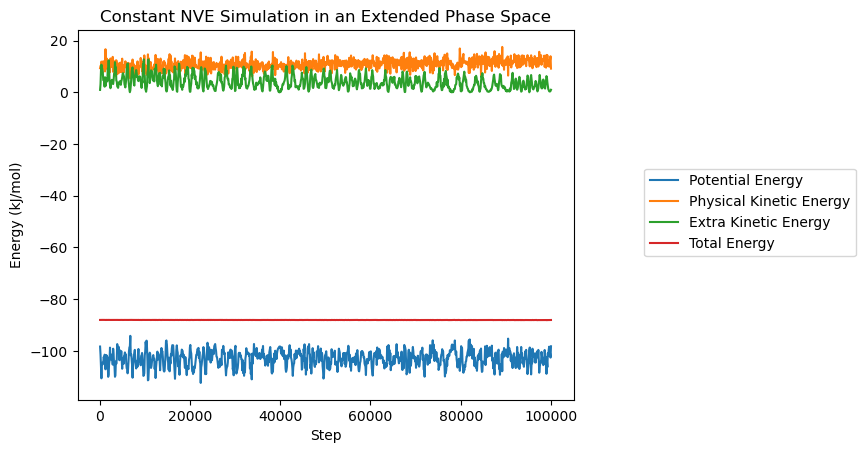

In [8]:
stream.seek(0)
data = pd.read_csv(stream)

steps = data['#"Step"']
potential = data["Potential Energy (kJ/mole)"]
physical_kinetic = data["Kinetic Energy (kJ/mole)"]
extra_kinetic = data["Extension Kinetic Energy (kJ/mole)"]
total = potential + physical_kinetic + extra_kinetic

fig, ax = plt.subplots()
ax.plot(steps, potential, label="Potential Energy")
ax.plot(steps, physical_kinetic, label="Physical Kinetic Energy")
ax.plot(steps, extra_kinetic, label="Extra Kinetic Energy")
ax.plot(steps, total, label="Total Energy")
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('Step')
ax.set_ylabel('Energy (kJ/mol)')
ax.set_title("Constant NVE Simulation in an Extended Phase Space")
plt.show()

Plotting the trajectory of the DVs and their attached CVs to check the coupling between them.

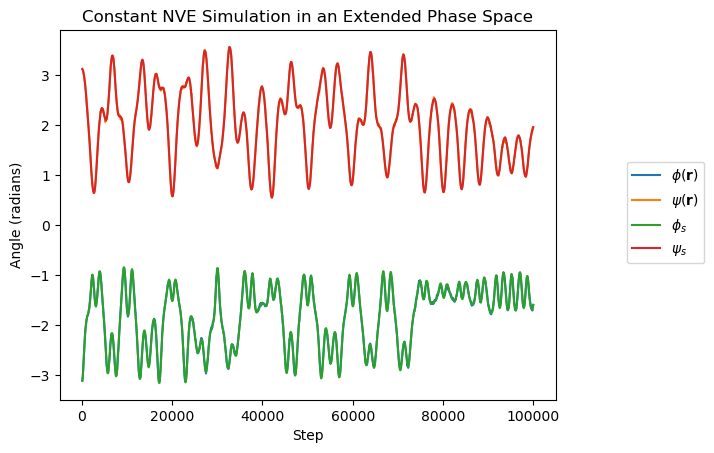

In [9]:
fig, ax = plt.subplots()
ax.plot(steps, np.unwrap(data["phi (rad)"]), label=r"$\phi({\bf r})$")
ax.plot(steps, np.unwrap(data["psi (rad)"]), label=r"$\psi({\bf r})$")
ax.plot(steps, np.unwrap(data["phi_s (rad)"]), label=r"$\phi_s$")
ax.plot(steps, np.unwrap(data["psi_s (rad)"]), label=r"$\psi_s$")
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('Step')
ax.set_ylabel('Angle (radians)')
ax.set_title("Constant NVE Simulation in an Extended Phase Space")
plt.show()